Pairwise Training:

    Train the model on pairs of teams. For each game, 
you can have a binary outcome: either Team A wins or Team B wins. This can help the model learn the matchups more explicitly.


28
Index(['TEAM_ID', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'Home_Away',
       'TEAM_ID_OPP', 'MATCHUP_ID', 'TS%', 'ORtg', 'PER%', 'PTS_PER_MIN',
       'eFG%', 'AST%', 'FG_PCT_DIFF', 'FG3_PCT_DIFF', 'FT_PCT_DIFF',
       'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF', 'PER%_DIFF',
       'PTS_DIFF', 'PTS_PER_MIN_DIFF', 'YEAR', 'MONTH', 'DAY', 'WL_encoded'],
      dtype='object')


C:\Users\ghadf\AppData\Local\Temp\ipykernel_13720\1481350070.py:45: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = preprocessor_data.corr()


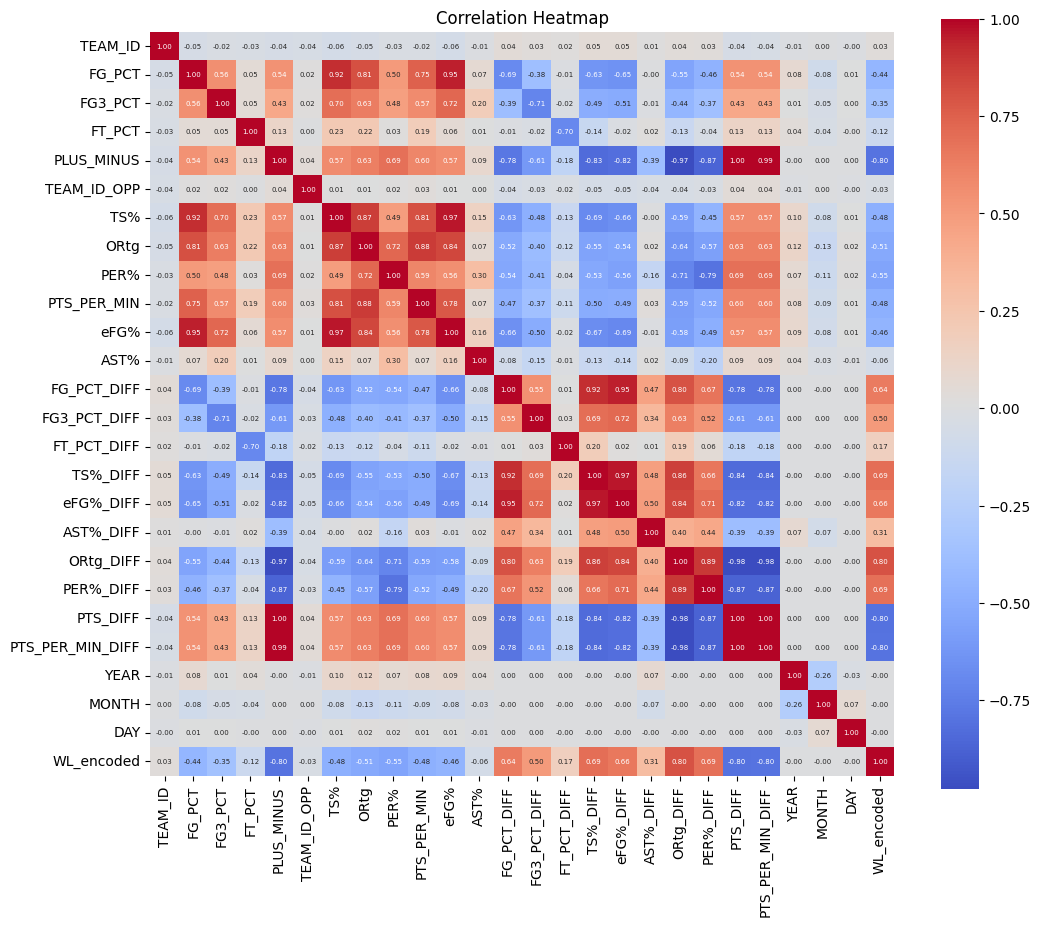

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import preprocessing
# Load the data
data = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\nba_threeptera_prepreprocess_data.csv')


# Reorder the columns in the DataFrame to place 'WL_encoded' at the end
preprocessor_data = data[[col for col in data.columns if col != 'WL'] + ['WL']]

#drop the columns that are not needed
x_excluded_independent_variables = ['GAME_DATE', 'TEAM_ABBREVIATION', 'WL', 'FGA', 'TOV', 'TEAM_NAME', 'GAME_ID', 'PPM', 'RPM', 'APM', 'SPM', 'BPM', 'TPM',
                                    'PER', 'OPM', 'DPM', 'USG%', 'FG3A', 'OREB', 'PF', 'MIN', 'PTS', 'FGM', 'FG3M', 'FTM', 'FTA', 'PTS', 'REB', 
                                    'AST', 'PF', 'STL', 'BLK', 'DREB', 'Offensive_Possessions', 'SEASON_ID', 'MATCHUP', #, 
                                    'PTS_OPP', 'FGM_OPP', 'FG3M_OPP', 'FTM_OPP', 'FTA_OPP', 'PTS_OPP', 'REB_OPP', 'OREB_OPP', 'FGA_OPP', 'FG3A_OPP', 'OREB_OPP', 
                                    'AST_OPP', 'TOV_OPP', 'STL_OPP', 'BLK_OPP', 'SEASON_ID_OPP', 'Home_Away_OPP' #,  'Defensive_Possessions'
                                    , 'TEAM_NAME_OPP', 'WL_OPP', 'MIN_OPP', 'PF_OPP', 'DREB_OPP','PTS_PER_MIN_OPP'] #, 'TEAM_ID_OPP'

#drop the columns that are not needed
preprocessor_data = preprocessor_data.drop(x_excluded_independent_variables, axis=1)
print(len(preprocessor_data.columns))
print(preprocessor_data.columns)

# Create a correlation matrix for the selected columns
correlation_matrix = preprocessor_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True,
            annot_kws={'size': 5})  # Adjust the font size (here it's set to 8)


plt.title('Correlation Heatmap')
plt.show()

In [2]:
##UPDATE: because they are identification for the season and team, I would like to update my preprocessor so the variable is updated to ordinal vs non ordinal categorical variables 

# Define the columns for the dependent (y) and independent (X) variables
y_column = 'WL_encoded'


# Combine y_column with x_excluded_independent_variables
columns_to_drop = [y_column] #+ x_excluded_independent_variables

# Define feature lists
categorical_features = [ 'TEAM_ID', 'TEAM_ID_OPP', 'Home_Away', 'MATCHUP_ID'] #'SEASON_ID', 'MATCHUP'
numerical_features = [col for col in preprocessor_data.columns if col not in categorical_features + columns_to_drop]
#numerical features being: TS%, eFG%, APM, OPM, DPM, RPM, BPM, TPM, PER%, PER, ORtg, Plus_minus, fg3_pct, fg_pct, ftm, pts


# Use OrdinalEncoder for the categorical columns
ordinal_encoder = OrdinalEncoder()
#preprocessor_data[categorical_features] = ordinal_encoder.fit_transform(preprocessor_data[categorical_features])

# Fit the encoder on the first dataset's categorical columns
ordinal_encoder.fit(preprocessor_data[categorical_features])

# Transform the first dataset using the fitted encoder in a separate variable
all_encoded = preprocessor_data
all_encoded[categorical_features] = ordinal_encoder.transform(preprocessor_data[categorical_features])
# Convert all_encoded to a pandas DataFrame
all_encoded = pd.DataFrame(all_encoded)
#print(all_encoded.head())
#preprocessor_data[categorical_features] = ordinal_encoder.transform(preprocessor_data[categorical_features])
#print(preprocessor_data.head())


# Define transformers
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
    #,('onehot', OneHotEncoder(handle_unknown='ignore')) # Use OneHotEncoder for non-tree-based models
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Define X and y
X = all_encoded.drop(columns=columns_to_drop, axis=1)
print('before preprocessing = ', X.shape)
#print(X.head())
y = all_encoded[y_column]
print('y shape = ', y.shape)
# view unique values in the target variable
#print(y.unique())

# Use LabelEncoder to encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#print(X.isnull().sum())
#print(X.dtypes)
# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)
print('after preprocessing = ', X_preprocessed.shape)
#print X_preprocessed to see what it looks like
#print(X_preprocessed)

tmp_num = numerical_transformer.fit_transform(X[numerical_features])
print(pd.DataFrame(tmp_num, columns=numerical_features).isnull().sum())

tmp_cat = categorical_transformer.fit_transform(X[categorical_features])
print(pd.DataFrame(tmp_cat).isnull().sum())


before preprocessing =  (13704, 27)
y shape =  (13704,)
after preprocessing =  (13704, 27)
FG_PCT              0
FG3_PCT             0
FT_PCT              0
PLUS_MINUS          0
TS%                 0
ORtg                0
PER%                0
PTS_PER_MIN         0
eFG%                0
AST%                0
FG_PCT_DIFF         0
FG3_PCT_DIFF        0
FT_PCT_DIFF         0
TS%_DIFF            0
eFG%_DIFF           0
AST%_DIFF           0
ORtg_DIFF           0
PER%_DIFF           0
PTS_DIFF            0
PTS_PER_MIN_DIFF    0
YEAR                0
MONTH               0
DAY                 0
dtype: int64
0    0
1    0
2    0
3    0
dtype: int64


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Convert the numpy arrays back to pandas DataFrames
feature_names = preprocessor.transformers_[0][-1] + preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()
print(feature_names)

X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)


# Fit the preprocessor first
preprocessor.fit(X_train)

# Now access the named transformers after fitting
#ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
#all_feature_names = np.concatenate([numerical_features, ohe_feature_names])


#print('Original number of features:', len(numerical_features + categorical_features))
#print('Number of features after one-hot encoding:', len(all_feature_names))
#print(ohe_feature_names)
#print(all_feature_names)




['FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'TS%', 'ORtg', 'PER%', 'PTS_PER_MIN', 'eFG%', 'AST%', 'FG_PCT_DIFF', 'FG3_PCT_DIFF', 'FT_PCT_DIFF', 'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF', 'PER%_DIFF', 'PTS_DIFF', 'PTS_PER_MIN_DIFF', 'YEAR', 'MONTH', 'DAY', 'TEAM_ID', 'TEAM_ID_OPP', 'Home_Away', 'MATCHUP_ID']


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS',
                                  'TS%', 'ORtg', 'PER%', 'PTS_PER_MIN', 'eFG%',
                                  'AST%', 'FG_PCT_DIFF', 'FG3_PCT_DIFF',
                                  'FT_PCT_DIFF', 'TS%_DIFF', 'eFG%_DIFF',
                                  'AST%_DIFF', 'ORtg_DIFF', 'PER%_DIFF',
                                  'PTS_DIFF', 'PTS_PER_MIN_DIFF', 'YEAR',
                                  'MONTH', 'DAY']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['TEAM_ID', 'TEAM_ID_OPP', 'Home_Away',
                                  'MATCHUP_ID'])])

c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Model Decision Tree saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\decision_tree.joblib
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1371
           1       1.00      1.00      1.00      1370

    accuracy                           1.00      2741
   macro avg       1.00      1.00      1.00      2741
weighted avg       1.00      1.00      1.00      2741



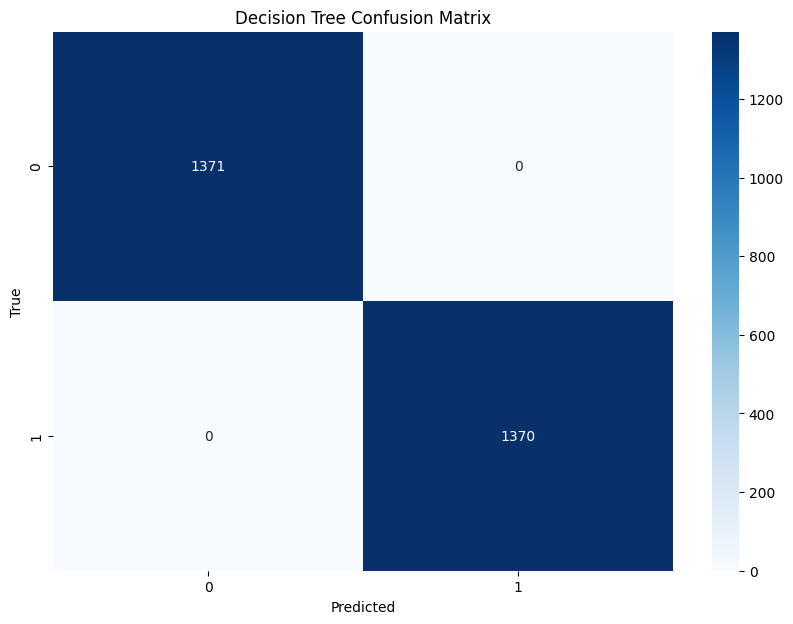

Decision Tree Accuracy: 1.0000
--------------------------------------------------
Model Random Forest saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\random_forest.joblib
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1371
           1       1.00      1.00      1.00      1370

    accuracy                           1.00      2741
   macro avg       1.00      1.00      1.00      2741
weighted avg       1.00      1.00      1.00      2741



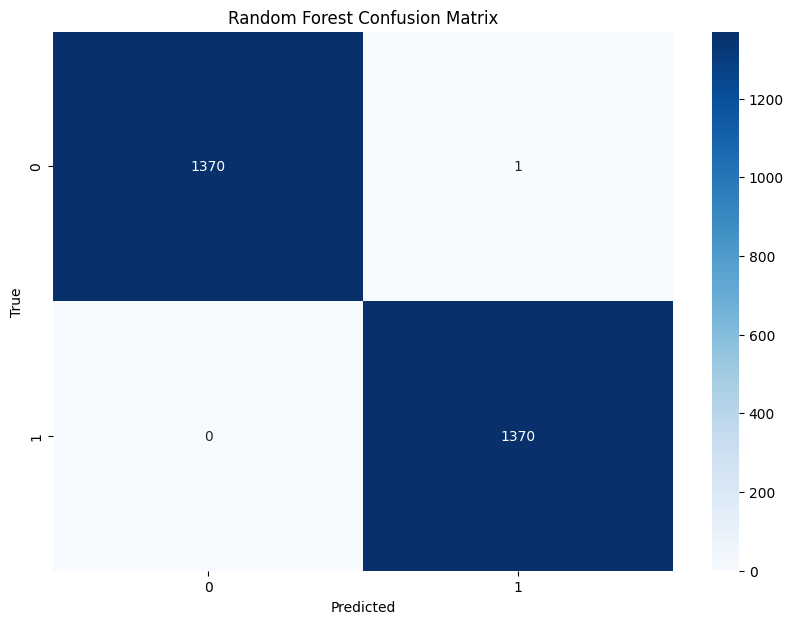

Random Forest Accuracy: 0.9996
--------------------------------------------------
Model Gradient Boosting saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\gradient_boosting.joblib
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1371
           1       1.00      1.00      1.00      1370

    accuracy                           1.00      2741
   macro avg       1.00      1.00      1.00      2741
weighted avg       1.00      1.00      1.00      2741



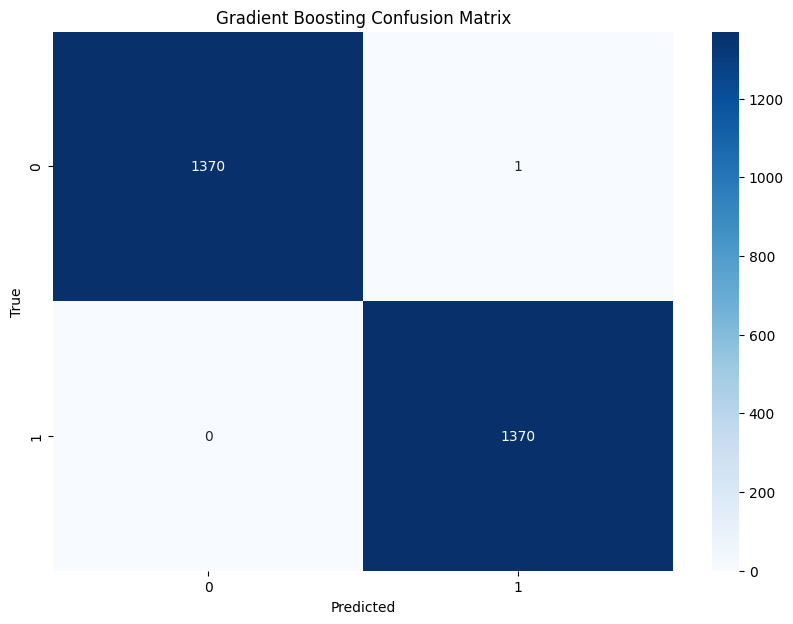

Gradient Boosting Accuracy: 0.9996
--------------------------------------------------
Model AdaBoost saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\adaboost.joblib
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1371
           1       1.00      1.00      1.00      1370

    accuracy                           1.00      2741
   macro avg       1.00      1.00      1.00      2741
weighted avg       1.00      1.00      1.00      2741



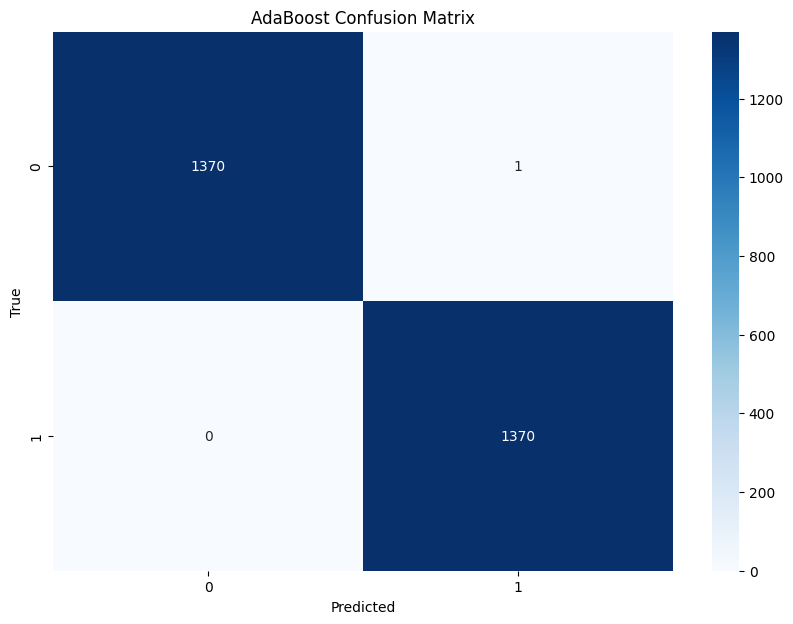

AdaBoost Accuracy: 0.9996
--------------------------------------------------
Model XGBoost saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\xgboost.joblib
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1371
           1       1.00      1.00      1.00      1370

    accuracy                           1.00      2741
   macro avg       1.00      1.00      1.00      2741
weighted avg       1.00      1.00      1.00      2741



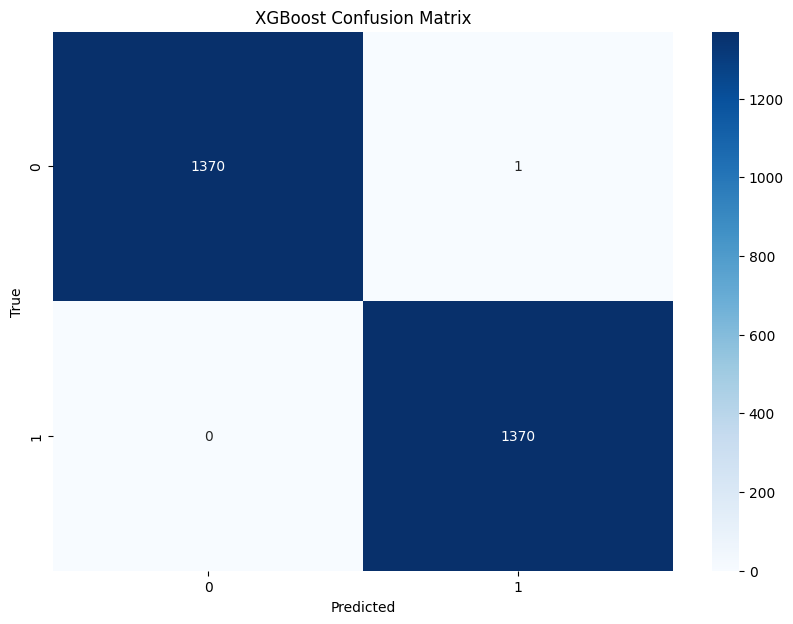

c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBoost Accuracy: 0.9996
--------------------------------------------------


In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from joblib import dump, load
import os

# Define the path to the directory where you want to save the models
MODEL_DIR = r"C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models"
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
# Define a function to save the models
def save_model(model, name):
    path = os.path.join(MODEL_DIR, f"{name.replace(' ', '_').lower()}.joblib")
    dump(model, path)
    return path


# Count the classes
class_counts = np.bincount(y_encoded)
# Calculate the scale_pos_weight for XGBoost
scale_pos_weight = float(class_counts[0] / class_counts[1])

# Note: Some models have hyperparameters set to avoid potential issues. 
# You should adjust these based on understanding and dataset specifics.

#Bin-classification models
models = [
    ("Logistic Regression", LogisticRegression(max_iter=10000)),
    ("Ridge Classifier", RidgeClassifier()), 
    ("SGD Classifier", SGDClassifier(max_iter=1000, tol=1e-3)),
    ("Decision Tree", DecisionTreeClassifier()), 
    ("Random Forest", RandomForestClassifier(class_weight="balanced")), # Adjusted for imbalance
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("SVM", SVC()),
    ("Gaussian Naive Bayes", GaussianNB()),
    ("K-Neighbors Classifier", KNeighborsClassifier()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos_weight)), # Adjusted for imbalance
    ("MLP Classifier", MLPClassifier(max_iter=1000))
]

#split the models into tree and non-tree based models
tree_models = ["XGBoost", "Decision Tree", "Random Forest", "Gradient Boosting", "AdaBoost"]
non_tree_models = ["Logistic Regression", "Ridge Classifier", "SGD Classifier", "SVM", "Gaussian Naive Bayes", "K-Neighbors Classifier", "MLP Classifier"]

#filter the models variable to only include tree-based models
models = [model for model in models if model[0] in tree_models]

# filter the models variable to only include non-tree-based models
#models = [model for model in models if model[0] in non_tree_models]
#print(models)

num_classes = len(np.unique(y_encoded))

#Multi-classification models
#models = [
#    ("Logistic Regression", LogisticRegression(multi_class='ovr', max_iter=10000)),
#    ("Ridge Classifier", RidgeClassifier()), 
#    ("SGD Classifier", SGDClassifier(max_iter=1000, tol=1e-3)),
#    ("Decision Tree", DecisionTreeClassifier()), 
#    ("Random Forest", RandomForestClassifier(class_weight="balanced")), # Adjusted for imbalance
#    ("Gradient Boosting", GradientBoostingClassifier()),
#    ("AdaBoost", AdaBoostClassifier(algorithm='SAMME')),
#    ("SVM", SVC(probability=True)), # Added probability=True for decision boundary plotting
#    ("Gaussian Naive Bayes", GaussianNB()),
#    ("K-Neighbors Classifier", KNeighborsClassifier()),
#    ("XGBoost", XGBClassifier(use_label_encoder=False, 
#                              eval_metric="mlogloss", 
#                              objective="multi:softprob", 
#                              num_class=num_classes)), 
#    ("MLP Classifier", MLPClassifier(max_iter=1000))
#]


def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)


def display_confusion_matrix(classifier, X_test, y_test):
    matrix = confusion_matrix(y_test, classifier.predict(X_test), labels=classifier.classes_)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt="d",
                xticklabels=classifier.classes_,
                yticklabels=classifier.classes_, cmap=plt.cm.Blues)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

from sklearn.decomposition import PCA

from sklearn.base import clone

# Continue using your PCA as before
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train models, plot decision boundaries, and display confusion matrices
results = []
for name, model in models:
    model.fit(X_train, y_train)  # Training on original data
    y_pred = model.predict(X_test)  # Predicting on original data
    
    # Save the trained model
    saved_path = save_model(model, name)
    print(f"Model {name} saved to {saved_path}")
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results.append((name, accuracy))
    
    # Display classification report
    report = classification_report(y_test, y_pred)
    print(f"{name} Classification Report:")
    print(report)
    
    # Display confusion matrix (using the original X_test)
    display_confusion_matrix(model, X_test, y_test)  
    
    # Now for the decision boundary, we need to train the model again on PCA data.
    # Clone the model to avoid refitting the original one
    model_clone = clone(model)
    model_clone.fit(X_train_pca, y_train)
    
    # Plot decision boundaries using the model trained on PCA data
    #plt.figure(figsize=(10,6))
    #plot_decision_boundary(lambda x: model_clone.predict(x), X_train_pca, y_train)
    #plt.title(name)
    #plt.show()
    
    print(f"{name} Accuracy: {accuracy:.4f}")
    print("--------------------------------------------------")



In [5]:
# Fit the encoder on the first dataset's categorical columns
ordinal_encoder.fit(data[categorical_features])
#print(ordinal_encoder.categories_)
print(data[categorical_features].head())

#save the ordinal_encoder, label_encoder, and preprocessor to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing


MODEL_DIR = r"C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing"
saved_path = save_model(preprocessor, 'tree_preprocessor')
saved_path = save_model(label_encoder, 'label_encoder')
saved_path = save_model(ordinal_encoder, 'ordinal_encoder')
print(f"Model saved to {saved_path}")

      TEAM_ID  TEAM_ID_OPP Home_Away MATCHUP_ID
0  1610612737   1610612766      Away     ATLCHA
1  1610612737   1610612755      Away     ATLPHI
2  1610612737   1610612754      Away     ATLIND
3  1610612737   1610612740      Home     ATLNOP
4  1610612737   1610612763      Home     ATLMEM
Model saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\ordinal_encoder.joblib


In [6]:
#read "unseen" data so we can test what these models would predict for the 2022 playoffs
#prediction_data = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\nba_test_unseen_dataset.csv')
prediction_data = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\23_24_season_games_clean.csv')

#print(prediction_data.head())

# Drop the columns that are not needed Matchup
#prediction_data = prediction_data.drop(columns=['MATCHUP'])

    
# Define the desired feature order
#feature_order = ['TEAM_ID', 'MATCHUP', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'Home_Away', 'FG_PCT_OPP', 'FG3_PCT_OPP', 
                  #'FT_PCT_OPP', 'PLUS_MINUS_OPP', 'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%', 'TS%_OPP', 'eFG%_OPP', 'AST%_OPP', 
                 #'DRtg', 'DPER%', 'YEAR', 'MONTH', 'DAY',
                 #'FG_PCT_DIFF','FG3_PCT_DIFF','FT_PCT_DIFF','TS%_DIFF','eFG%_DIFF','AST%_DIFF','ORtg_DIFF','PER%_DIFF'] #, 'MATCHUP'

feature_names = ['PTS_PER_MIN', 'PTS_DIFF', 'PTS_PER_MIN_DIFF','FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%', 
                     'FG_PCT_DIFF', 'FG3_PCT_DIFF', 'FT_PCT_DIFF', 'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF', 'PER%_DIFF', 'YEAR', 'MONTH', 'DAY', 'TEAM_ID', 
                     'TEAM_ID_OPP', 'Home_Away', 'MATCHUP_ID']

feature_order = ['PTS_PER_MIN', 'PTS_DIFF', 'PTS_PER_MIN_DIFF','TEAM_ID', 'TEAM_ID_OPP', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'Home_Away', 'MATCHUP_ID',# 'FG_PCT_OPP', 'FG3_PCT_OPP',  'SEASON_ID', 'GAME_ID'
                   'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%', #'FT_PCT_OPP', 'PLUS_MINUS_OPP','TS%_OPP', 'eFG%_OPP', 'AST%_OPP', , 'MATCHUP'
                  'YEAR', 'MONTH', 'DAY', #'DRtg', 'DPER%',
                 'FG_PCT_DIFF','FG3_PCT_DIFF','FT_PCT_DIFF','TS%_DIFF','eFG%_DIFF','AST%_DIFF','ORtg_DIFF','PER%_DIFF'] #, 'MATCHUP'

#does feature_names = feature_order?
print(len(feature_names))
print(len(feature_order))

feature_order = ['FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'TS%', 'ORtg', 'PER%', 'PTS_PER_MIN', 'eFG%', 'AST%', 'FG_PCT_DIFF', 'FG3_PCT_DIFF', 'FT_PCT_DIFF', 'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF', 'PER%_DIFF', 'PTS_DIFF', 'PTS_PER_MIN_DIFF', 'YEAR', 'MONTH', 'DAY', 'TEAM_ID', 'TEAM_ID_OPP', 'Home_Away', 'MATCHUP_ID']
print("Columns in prediction_data: ", prediction_data.columns)
print("Columns in feature_order: ", feature_order)

missing_columns = [col for col in feature_order if col not in prediction_data.columns]
print("Missing columns: ", missing_columns)


feature_order = list(feature_order)  # Ensure it's a list
prediction_data = prediction_data[feature_order]

#print(prediction_data.head())

27
27
Columns in prediction_data:  Index(['PTS_PER_MIN', 'PTS_DIFF', 'PTS_PER_MIN_DIFF', 'TEAM_ID', 'TEAM_ID_OPP',
       'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'Home_Away', 'MATCHUP_ID',
       'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%', 'YEAR', 'MONTH', 'DAY',
       'FG_PCT_DIFF', 'FG3_PCT_DIFF', 'FT_PCT_DIFF', 'TS%_DIFF', 'eFG%_DIFF',
       'AST%_DIFF', 'ORtg_DIFF', 'PER%_DIFF'],
      dtype='object')
Columns in feature_order:  ['FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'TS%', 'ORtg', 'PER%', 'PTS_PER_MIN', 'eFG%', 'AST%', 'FG_PCT_DIFF', 'FG3_PCT_DIFF', 'FT_PCT_DIFF', 'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF', 'PER%_DIFF', 'PTS_DIFF', 'PTS_PER_MIN_DIFF', 'YEAR', 'MONTH', 'DAY', 'TEAM_ID', 'TEAM_ID_OPP', 'Home_Away', 'MATCHUP_ID']
Missing columns:  []


In [7]:
assert set(feature_order) == set(prediction_data.columns)


In [8]:
#############################################################################################################

#load the encoder from C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models
ordinal_encoder = load(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\ordinal_encoder.joblib')

# Fit the encoder on the first dataset's categorical columns
ordinal_encoder.fit(data[categorical_features])

#save the encoder to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models
saved_path = save_model(ordinal_encoder, 'ordinal_encoder')
print(f"Model saved to {saved_path}")

# Transform the categorical columns in dataset1 using the fitted encoder
#print(data.head())
#preprocessor_data[categorical_features] = ordinal_encoder.transform(preprocessor_data[categorical_features])
#print(preprocessor_data.head())

print(prediction_data.head())
# Use OrdinalEncoder for the categorical columns
prediction_data[categorical_features] = ordinal_encoder.transform(prediction_data[categorical_features])
print(prediction_data.head())

# Check if the categorical columns in dataset1 and dataset2 are the same
if set(prediction_data[categorical_features]) != set(preprocessor_data[categorical_features]):
    raise ValueError("Categorical columns in dataset1 do not match dataset2")



Model saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\ordinal_encoder.joblib
     FG_PCT   FG3_PCT    FT_PCT  PLUS_MINUS       TS%        ORtg        PER%  \
0  0.466249  0.349655  0.811272   -0.733333  0.565746  109.320620  118.127497   
1  0.469766  0.341616  0.737743    1.845528  0.565838  108.248419  117.738334   
2  0.464571  0.360043  0.783743    0.457500  0.570568  110.011593  117.893095   
3  0.473682  0.363579  0.747414    7.348988  0.582406  112.599600  124.944067   

   PTS_PER_MIN      eFG%       AST%  FG_PCT_DIFF  FG3_PCT_DIFF  FT_PCT_DIFF  \
0     0.460023  0.527802  28.923854    -0.001937      0.005679    -0.042106   
1     0.462266  0.531888  28.389080    -0.019586      0.001584     0.032873   
2     0.459191  0.530044  27.329435    -0.001959     -0.010820    -0.015577   
3     0.486492  0.551549  28.080268    -0.033904     -0.007530     0.013700   

   TS%_DIFF  eFG%_DIFF  AST%_DIFF  ORtg_DIFF  PER%

In [9]:
#check for these team_id's in the prediction_data [1610612737, 1610612738, 1610612739, 1610612740, 1610612741, 1610612742, 1610612743, 1610612744, 1610612745, 1610612746, 1610612747, 1610612748, 1610612749, 1610612750, 1610612751, 1610612752, 1610612753, 1610612754, 1610612755, 1610612756, 1610612757, 1610612758, 1610612759, 1610612760, 1610612761, 1610612762, 1610612763, 1610612764, 1610612765, 1610612766]
prediction_teams = prediction_data['TEAM_ID'].unique()
print(prediction_teams)

# Fit the encoder on the first dataset's categorical columns
#ordinal_encoder.fit(preprocessor_data[categorical_features])

# Use OrdinalEncoder for the categorical columns
#prediction_data[categorical_features] = ordinal_encoder.transform(prediction_data[categorical_features])

print(prediction_data.head())



[19. 10. 18. 12.]
     FG_PCT   FG3_PCT    FT_PCT  PLUS_MINUS       TS%        ORtg        PER%  \
0  0.466249  0.349655  0.811272   -0.733333  0.565746  109.320620  118.127497   
1  0.469766  0.341616  0.737743    1.845528  0.565838  108.248419  117.738334   
2  0.464571  0.360043  0.783743    0.457500  0.570568  110.011593  117.893095   
3  0.473682  0.363579  0.747414    7.348988  0.582406  112.599600  124.944067   

   PTS_PER_MIN      eFG%       AST%  FG_PCT_DIFF  FG3_PCT_DIFF  FT_PCT_DIFF  \
0     0.460023  0.527802  28.923854    -0.001937      0.005679    -0.042106   
1     0.462266  0.531888  28.389080    -0.019586      0.001584     0.032873   
2     0.459191  0.530044  27.329435    -0.001959     -0.010820    -0.015577   
3     0.486492  0.551549  28.080268    -0.033904     -0.007530     0.013700   

   TS%_DIFF  eFG%_DIFF  AST%_DIFF  ORtg_DIFF  PER%_DIFF  PTS_DIFF  \
0  0.004521   0.003483  -1.699241   0.371331  -2.494972      -235   
1 -0.014015  -0.015418  -0.806958  -1.8227

In [10]:
#load in preprocessing from C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models
preprocessor = load(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\preprocessing\tree_preprocessor.joblib')

# Preprocess X_new
X_new_preprocessed = preprocessor.transform(prediction_data)
print(X_new_preprocessed.shape)
#print(X_new_preprocessed)
X_unseen_preprocessed = pd.DataFrame(X_new_preprocessed, columns=feature_names)
print(X_unseen_preprocessed.head())


(4, 27)
   PTS_PER_MIN  PTS_DIFF  PTS_PER_MIN_DIFF    FG_PCT   FG3_PCT      FT_PCT  \
0     0.458383  0.346745          0.811908 -0.727488  0.559563  108.096737   
1     0.461869  0.338770          0.738618  1.842831  0.559653  107.036544   
2     0.456720  0.357049          0.784468  0.459401  0.564338  108.779971   
3     0.465750  0.360557          0.748257  7.328059  0.576062  111.338994   

   PLUS_MINUS       TS%      ORtg       PER%      eFG%      AST%  FG_PCT_DIFF  \
0  117.176366  0.457794  0.520671  28.840623 -0.002435  0.002999    -0.047594   
1  116.790344  0.460016  0.524718  28.307412 -0.020058 -0.001082     0.027823   
2  116.943856  0.456970  0.522892  27.250861 -0.002457 -0.013445    -0.020909   
3  123.937899  0.484014  0.544195  27.999501 -0.034354 -0.010166     0.008538   

   FG3_PCT_DIFF  FT_PCT_DIFF  TS%_DIFF  eFG%_DIFF  AST%_DIFF    ORtg_DIFF  \
0      0.001762     0.002521 -1.703194   0.365740  -2.484662  -234.271601   
1     -0.016755    -0.016342 -0.810922  -

In [11]:
# Load the trained Random Forest model
MODEL_DIR = r"C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models"
xgboost = os.path.join(MODEL_DIR, "xgboost.joblib")
trained_rf = load(xgboost)

original_feature_order = ['FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'TS%', 'ORtg', 'PER%', 'PTS_PER_MIN', 'eFG%', 'AST%', 'FG_PCT_DIFF', 'FG3_PCT_DIFF', 'FT_PCT_DIFF', 'TS%_DIFF', 'eFG%_DIFF', 'AST%_DIFF', 'ORtg_DIFF', 'PER%_DIFF', 'PTS_DIFF', 'PTS_PER_MIN_DIFF', 'YEAR', 'MONTH', 'DAY', 'TEAM_ID', 'TEAM_ID_OPP', 'Home_Away', 'MATCHUP_ID']
X_unseen_preprocessed = X_unseen_preprocessed[original_feature_order]

# Predict using the trained model
predictions_rf = trained_rf.predict(X_unseen_preprocessed)

# Convert predictions back from encoded form to original labels
decoded_predictions_rf = label_encoder.inverse_transform(predictions_rf)

# Add predictions as a new column to the original dataframe
prediction_data['PREDICTION'] = decoded_predictions_rf

# Inverse transform the encoded categorical columns back to their original form
prediction_data[categorical_features] = ordinal_encoder.inverse_transform(prediction_data[categorical_features])

# Display the results with the original values
#print(prediction_data.head())

# put YEAR, MONTH, DAY into a date column
prediction_data['Date'] = pd.to_datetime(prediction_data[['YEAR', 'MONTH', 'DAY']])
#sort by date
prediction_data = prediction_data.sort_values(by=['Date'])
print(prediction_data.head())

     FG_PCT   FG3_PCT    FT_PCT  PLUS_MINUS       TS%        ORtg        PER%  \
0  0.466249  0.349655  0.811272   -0.733333  0.565746  109.320620  118.127497   
1  0.469766  0.341616  0.737743    1.845528  0.565838  108.248419  117.738334   
2  0.464571  0.360043  0.783743    0.457500  0.570568  110.011593  117.893095   
3  0.473682  0.363579  0.747414    7.348988  0.582406  112.599600  124.944067   

   PTS_PER_MIN      eFG%       AST%  FG_PCT_DIFF  FG3_PCT_DIFF  FT_PCT_DIFF  \
0     0.460023  0.527802  28.923854    -0.001937      0.005679    -0.042106   
1     0.462266  0.531888  28.389080    -0.019586      0.001584     0.032873   
2     0.459191  0.530044  27.329435    -0.001959     -0.010820    -0.015577   
3     0.486492  0.551549  28.080268    -0.033904     -0.007530     0.013700   

   TS%_DIFF  eFG%_DIFF  AST%_DIFF  ORtg_DIFF  PER%_DIFF  PTS_DIFF  \
0  0.004521   0.003483  -1.699241   0.371331  -2.494972      -235   
1 -0.014015  -0.015418  -0.806958  -1.822796  -1.291241     

In [12]:
# Assuming you've already read in your df1
df1 = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\team_ids.csv')

# Filter df1 to only unique TEAM_ID, TEAM_NAME, and SEASON_ID
unique_teams = df1[['TEAM_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION']].drop_duplicates()

# Merge unique_teams with prediction_data
prediction_data = prediction_data.merge(unique_teams, on='TEAM_ID', how='left')
#print(prediction_data.head())
#print(len(prediction_data))

# Drop unnecessary columns
columns_to_drop = ["TEAM_ID", "TEAM_ID_OPP", "YEAR", "MONTH", "DAY"]
prediction_data = prediction_data.drop(columns=columns_to_drop)  # using errors='ignore' to avoid any error if columns are not present

# filter for todays games
today = pd.Timestamp.today().normalize()
prediction_data = prediction_data[prediction_data['Date'] == today]

# print this list:
season_pred = prediction_data[['TEAM_NAME', 'TEAM_ABBREVIATION', 'Date', 'MATCHUP_ID', 'Home_Away']]
print(season_pred.head())

#save this to a csv
season_pred.to_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\tree_season_pred.csv', index=False)

            TEAM_NAME TEAM_ABBREVIATION       Date MATCHUP_ID Home_Away
0        Phoenix Suns               PHX 2023-10-26     LALPHX      Away
1  Los Angeles Lakers               LAL 2023-10-26     LALPHX      Home
2  Philadelphia 76ers               PHI 2023-10-26     MILPHI      Away
3     Milwaukee Bucks               MIL 2023-10-26     MILPHI      Home


In [22]:
from datetime import datetime
import pandas as pd
import os

# 1. Create a DataFrame for today's outcomes based on prediction_data
today_predictions = prediction_data.copy()

for name, model in models:
    predictions_model = model.predict(X_unseen_preprocessed)
    decoded_predictions_model = label_encoder.inverse_transform(predictions_model)
    today_predictions[f'{name}_PREDICTION'] = decoded_predictions_model

# 2. Add today's date and recording timestamp
today_predictions['date_prediction_recorded'] = pd.Timestamp.today()

#add a day to the date
today_predictions['Date'] = today_predictions['Date'] + pd.DateOffset(days=2)

#filter for ATLCHA matchup_id
#today_predictions = today_predictions[today_predictions['MATCHUP_ID'] == 'ATLCHA']

# Define the path to the saved predictions
saved_predictions_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\tree_season_pred.csv'

# 3. Check if the saved predictions file exists
if not os.path.exists(saved_predictions_path):
    # If it doesn't exist, create it from today's predictions
    today_predictions.to_csv(saved_predictions_path, index=False)
    print(today_predictions.shape)
else:
    # If it exists, load it and update
    saved_predictions = pd.read_csv(saved_predictions_path)
    # Normalize the 'Date' column to remove time portion
    saved_predictions['Date'] = pd.to_datetime(saved_predictions['Date']).dt.normalize()

    print(saved_predictions.shape)

    print(today_predictions.shape)
    # 4. Concatenate existing and new predictions
    all_predictions = pd.concat([saved_predictions, today_predictions], ignore_index=True)
    
    # 5. Sort by date recorded, matchup id, and home_away
    all_predictions.sort_values(by=['date_prediction_recorded', 'MATCHUP_ID', 'Home_Away'], ascending=[True, True, True], inplace=True)
    
    # 6. Remove duplicates, keeping only the newest entry
    all_predictions.drop_duplicates(subset=['MATCHUP_ID', 'TEAM_NAME', 'Date'], keep='first', inplace=True)
    
    # Sort by date and reset index
    all_predictions = all_predictions.sort_values(by=['Date']).reset_index(drop=True)
    
    # 7. Save the updated DataFrame back to CSV
    all_predictions.to_csv(saved_predictions_path, index=False)

# 8. Display the results
print(all_predictions.head())
print(all_predictions.shape)

(24, 32)
(4, 32)
                TEAM_NAME TEAM_ABBREVIATION       Date MATCHUP_ID Home_Away  \
0       San Antonio Spurs               SAS 2023-10-25     DALSAS      Home   
1         Toronto Raptors               TOR 2023-10-25     MINTOR      Home   
2  Minnesota Timberwolves               MIN 2023-10-25     MINTOR      Away   
3       Memphis Grizzlies               MEM 2023-10-25     MEMNOP      Home   
4    New Orleans Pelicans               NOP 2023-10-25     MEMNOP      Away   

     FG_PCT   FG3_PCT    FT_PCT  PLUS_MINUS       TS%        ORtg        PER%  \
0  0.471964  0.370370  0.771503   -0.267925  0.565923  109.847075  120.336476   
1  0.454258  0.351115  0.785620    4.694372  0.561062  110.571862  121.855670   
2  0.461538  0.355345  0.768225   -2.504186  0.566614  109.120416  116.845716   
3  0.461420  0.343711  0.754930    4.099099  0.555688  109.755342  125.015490   
4  0.464642  0.348352  0.755110   -1.735484  0.561744  108.681655  117.798823   

   PTS_PER_MIN      e

In [21]:
#If you need to recreate tree_season_pred.csv with data

# The provided CSV data as a string
csv_data = """TEAM_NAME,TEAM_ABBREVIATION,Date,MATCHUP_ID,Home_Away,FG_PCT,FG3_PCT,FT_PCT,PLUS_MINUS,TS%,ORtg,PER%,PTS_PER_MIN,eFG%,AST%,FG_PCT_DIFF,FG3_PCT_DIFF,FT_PCT_DIFF,TS%_DIFF,eFG%_DIFF,AST%_DIFF,ORtg_DIFF,PER%_DIFF,PTS_DIFF,PTS_PER_MIN_DIFF,PREDICTION,Decision Tree_PREDICTION,Random Forest_PREDICTION,Gradient Boosting_PREDICTION,AdaBoost_PREDICTION,XGBoost_PREDICTION,date_prediction_recorded
Atlanta Hawks,ATL,2023-10-25,ATLCHA,Away,0.4534052865637336,0.3482502927019643,0.7929383602633154,-4.802643171806167,0.5580879546616546,108.05761213591556,115.11621421898744,0.4589957616923618,0.5202868135711788,26.38285114675461,0.0232278792654121,0.0179229026340765,-0.0153264199648079,0.0244561635139554,0.0265724829112332,2.531721717566999,4.7612720738780325,7.129983532726612,-1133.0,-0.0204547735366126,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
Toronto Raptors,TOR,2023-10-25,MINTOR,Home,0.4542583685565758,0.3511149439448072,0.7856199282883563,4.694372294372295,0.5610624860350798,110.57186203480092,121.85567045775107,0.4643515007043016,0.523490258951562,26.648204829228007,-0.0049112965304586,0.0051350560551928,-0.0026170954271664,3.499821297570094e-05,-0.0014539398330147,2.162242018354121,-4.690622466344166,-7.568972933790775,1099.0,0.019943166468213,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
Minnesota Timberwolves,MIN,2023-10-25,MINTOR,Away,0.4615384615384615,0.3553446685119283,0.7682250396196514,-2.504186046511628,0.5666139555107934,109.12041626258323,116.8457158807468,0.4720749313000735,0.5313649313649313,27.75446775446776,0.0143301623922597,0.0107341410774902,0.0173012761698223,0.0175355266028596,0.0146536556030695,1.7998674446028993,2.832316807155294,2.5239983380609203,-466.0,-0.0108591946202403,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
Memphis Grizzlies,MEM,2023-10-25,MEMNOP,Home,0.4614199831072688,0.3437109103544128,0.7549295774647887,4.099099099099099,0.5556875117640205,109.75534193708287,125.0154902898012,0.46635700315932,0.5228548715655587,28.454315099120585,-0.0172838951228922,0.0061354798145579,0.0361182353531156,-0.0028582655821384,-0.0084905998007318,-1.041425799089751,-4.310404440942492,-10.214823346711896,894.0,0.0166514140553449,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
New Orleans Pelicans,NOP,2023-10-25,MEMNOP,Away,0.4646422844136361,0.3483522892971712,0.7551098376313276,-1.735483870967742,0.5617442591428465,108.68165477276386,117.79882312961672,0.4662842672703206,0.5264342248202369,28.451709689100408,0.0014387053456818,0.01179348709226,0.0229955082806221,0.012345922699718,0.0115654632808183,0.2585881743918214,1.71056037789387,1.3637038662895549,-352.0,-0.0065078483871553,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
LA Clippers,LAC,2023-10-25,LACPOR,Home,0.4681548930337298,0.3834391602954516,0.7880878881423643,3.0051063829787235,0.5782255466939283,111.70017601496043,119.76118777127184,0.4696942765730537,0.5405835413912958,27.737798012434524,-0.0121861099139687,-0.0333685297573753,-0.020716286933905,-0.021232029648021,-0.0189533265343732,-1.0492923760533692,-3.4156521132147617,-2.386994853046033,705.0,0.0126285955949473,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
Portland Trail Blazers,POR,2023-10-25,LACPOR,Away,0.4517504263215969,0.3565307712282524,0.7853218210361067,-4.787665198237885,0.5581995505909765,108.39019419362631,114.47898993400814,0.4563246351172048,0.5206139030996088,24.6965593339352,0.0201517366054295,0.0084280341270513,-0.0100769412498199,0.0227893705451237,0.0229225836600435,4.624241151207311,5.030493767923616,8.738396794403172,-1102.0,-0.0202290840433354,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
Indiana Pacers,IND,2023-10-25,INDWAS,Home,0.4702080706179067,0.3565129391354633,0.7781873373807459,1.3448598130841125,0.5686501485189884,109.71369000397576,120.4134428470137,0.466320133940739,0.5349936948297604,29.57124842370744,-0.0066924041282624,-0.0019543284263461,0.002920558443975,-0.00361087131122,-0.0064222662583318,-2.0619547434100447,-0.7054737714396282,-3.001215517132792,268.0,0.0051456333760752,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
Washington Wizards,WAS,2023-10-25,INDWAS,Away,0.4645031528593172,0.3445262189512419,0.772597137014315,-5.01244019138756,0.5624744495707529,108.03623174858384,114.86941240255008,0.4607794278879697,0.5255762122200478,28.46270928462709,0.0111203993682321,0.0273601612381244,0.0126618271291113,0.018914741544124,0.0188131644970777,-0.4607699429258609,4.966603498307222,6.250837623182363,-1038.0,-0.0203368622996721,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
Orlando Magic,ORL,2023-10-25,HOUORL,Home,0.4498258598171528,0.3486052897817603,0.7816979051819184,-3.247619047619048,0.5519748274541759,106.45478902174632,116.85459210239806,0.4457150784842238,0.5154549412276883,27.34545058772312,0.0161315869913578,0.0144008111611126,-0.000758429120491,0.0190290821399127,0.0219154897597639,0.5596230620313847,3.0687142169485213,3.1492670900470188,-669.0,-0.0130772188452,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
Houston Rockets,HOU,2023-10-25,HOUORL,Away,0.4476989601564913,0.342471860024518,0.7569668246445498,-5.0738738738738745,0.5623764197360556,107.48813499736332,112.71313060291791,0.4593686029259864,0.526793987439514,25.141562853907136,0.0313567547144632,0.0212821852829253,0.02168099812092,0.0238545163646121,0.024209699574005,3.745163897424284,5.4987587524932025,10.095064025691258,-1137.0,-0.0213894309939655,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
Miami Heat,MIA,2023-10-25,DETMIA,Home,0.464004203888597,0.3649626378839995,0.7942977085884205,3.075,0.5766685090035687,111.01587489244876,119.57892455321075,0.4550104313883841,0.5375005971432666,29.28390579467826,-0.0109280578498264,-0.0166152989484252,-0.0113189851841651,-0.0116671277404035,-0.0096493296460324,-1.312382392879229,-3.3462826377169392,-4.177225134763944,865.0,0.0127901236129149,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
Detroit Pistons,DET,2023-10-25,DETMIA,Away,0.4400112233445566,0.3440353881278539,0.7640570934256056,-7.227317073170731,0.5446104068788228,104.88099649071076,112.19929038252998,0.4395528455284553,0.5076599326599327,26.346801346801342,0.0430978438217409,0.0174065683593622,0.0055922415199808,0.0391608875259845,0.0400605011105776,2.563662515118825,7.573074100455216,9.596354886740912,-1487.0,-0.0298228906317331,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
San Antonio Spurs,SAS,2023-10-25,DALSAS,Home,0.4719640971488912,0.3703703703703703,0.7715030408340573,-0.2679245283018868,0.5659227235263592,109.84707509595997,120.33647552442376,0.4656045206608327,0.5326821541710666,29.002111932418163,-0.0061115891558098,-0.0070061508407908,0.0050594591659427,-0.0005124186361443,-2.8451146799057803e-05,-1.9776347585620933,0.5293472686661573,0.3477432994766189,-74.0,-0.0015527749921944,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
Dallas Mavericks,DAL,2023-10-25,DALSAS,Away,0.4612257343225938,0.3598051433102979,0.7678742572359594,0.4279475982532751,0.5764676328009947,111.47348819526826,118.71174066551444,0.4608360315785644,0.5419249923772741,26.81674966968188,0.0027211347476149,-0.0049080026711467,-0.0008498669920569,-0.0097067154274477,-0.009492155065779,0.8972221669305291,-0.4043998448570818,2.709605919647629,78.0,0.0014522780771638,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
Chicago Bulls,CHI,2023-10-25,CHIOKC,Home,0.4660073497622136,0.3556709139531225,0.7940366972477064,-1.0549763033175354,0.56234820589157,108.21468617788122,117.22276140850111,0.4540584351401573,0.5271022481625595,27.46433203631648,0.0020324229650591,-0.0038374154397429,-0.0332457127697136,0.0069502687802066,0.0088188619773006,1.2834826489982127,0.7511692771288523,2.3968234154774706,-228.0,-0.0046613338882988,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
Oklahoma City Thunder,OKC,2023-10-25,CHIOKC,Away,0.4411568978756078,0.3314659197012138,0.7603455202892728,-3.948858447488584,0.5409816748383913,104.76762677658368,113.85111283846904,0.4476736435141981,0.5047606859482979,24.607115433836704,0.0174981775526713,0.019629633261317,0.0031200329466353,0.019962071526311,0.023134992906215,3.181174006204205,4.094346114307996,8.489265040641897,-797.0,-0.0171619627057969,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
New York Knicks,NYK,2023-10-25,BOSNYK,Home,0.4529629828614409,0.3563959318149262,0.7521985538401407,-0.1242990654205607,0.5559448402260684,109.31333190089,118.57709372325948,0.4505797579971643,0.5197979906516951,25.42309138773975,0.000131690418697,-0.0049977959960181,0.0060343778867669,0.0039369295625444,0.0044364281535669,2.143223039691776,-0.3220050254676181,0.1057928127471257,-24.0,-0.0001509836133785,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
Boston Celtics,BOS,2023-10-25,BOSNYK,Away,0.4590745669328104,0.3635460366526827,0.7927682737169518,3.197530864197531,0.5708316934370931,110.8384280335332,122.1416107998898,0.4616869033591201,0.5359527478171546,27.249381332586264,-0.012578021042496,-0.0182922265002766,-0.0146938832560157,-0.0182107066809662,-0.0218543409371321,-1.4445972731849783,-3.3332556959970105,-5.78244499186664,784.0,0.0133274096017545,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
Brooklyn Nets,BKN,2023-10-25,BKNCLE,Home,0.4685168148829602,0.3592396223975171,0.7736812251843449,1.6311111111111112,0.5756135706311926,110.06036639045315,118.60179142853151,0.4658607814868212,0.539507308596545,28.53930287232956,-0.0175325725777224,-0.0126840227677405,-0.006921448648032,-0.025522944540446,-0.024191418360425,-3.101180050671317,-2.2952750257179133,-1.8165041966859967,366.0,0.0068583236670736,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
Cleveland Cavaliers,CLE,2023-10-25,BKNCLE,Away,0.4543756368164836,0.3413820492454328,0.7614349775784753,-5.967307692307693,0.5501976727598785,105.92210441656776,112.50821424718262,0.4350689898277772,0.5151986867428959,26.41797803690705,0.0231852293340829,0.0266240159554769,0.0088921252252629,0.0269439666775415,0.0304369017233893,2.1414295699593247,6.029945659215173,11.022876436438423,-1151.0,-0.0251405825313278,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
Charlotte Hornets,CHA,2023-10-25,ATLCHA,Home,0.4516362825444611,0.3502832861189802,0.7550022232103157,-2.4403940886699504,0.5540988907477963,107.37993161468356,118.7353192449981,0.4516267648864334,0.5205720020070246,28.655851034175168,0.0125682314021922,-0.0030571918898193,0.0141750653180735,0.0116359223128712,0.0127003320472093,0.0027193645383007,2.8416650149362823,4.462436441540916,-481.0,-0.0098235543147451,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
Sacramento Kings,SAC,2023-10-25,SACUTA,Away,0.460633626097867,0.3518267929634641,0.7551573244425922,-1.902803738317757,0.5613581448956569,108.79364337803212,116.91461482871136,0.464861492874827,0.5285968214136345,27.493726474278542,0.0127011350929661,0.0061332346037308,0.0254968999202414,0.0176718965255842,0.0142656759091326,0.8688779378011269,2.377678312680942,2.7485453128254136,-321.0,-0.0084166145610855,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
Utah Jazz,UTA,2023-10-25,SACUTA,Home,0.4679287080857919,0.3666628920847016,0.7642247510668563,6.310729613733906,0.5847811838528403,112.58132022326646,121.93293042402009,0.4736040609137056,0.5494411438928607,27.65079045413352,-0.0219197743122436,-0.0196469590574264,-0.0016176153283671,-0.0417061795113976,-0.0410414546328101,-3.112045066679645,-6.655858082381499,-8.270906549734718,1356.0,0.0263910171999306,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-25 11:58:40.916720
"""

# to_csv the csv_data to data file path
data_path = r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\tree_season_pred.csv'
#with open(data_path, 'w') as f:
#    f.write(csv_data)

